# 06 — Model Evaluation & Backtesting
Systematic evaluation using walk-forward validation across multiple horizons.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from src.data_loader import fetch_multiple_stocks
from src.baselines import NaiveForecast, RandomWalkForecast, SMAForecast, ARIMAForecast
from src.evaluation import (backtest_model, backtest_cluster_model, compare_models,
                            walk_forward_split, compute_all_metrics,
                            plot_model_comparison_heatmap, plot_metrics_bar_chart,
                            statistical_test)

warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
SELECTED_TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "JPM", "V", "MA", "GS", "JNJ", "UNH", "LLY", "MRK", "ABBV", "XOM", "CVX", "PG", "KO", "PEP", "WMT", "HD", "CRM", "AMD", "NFLX", "DIS", "INTC", "BA", "GE"]

stock_data = fetch_multiple_stocks(SELECTED_TICKERS, period="2y")
cluster_labels = pd.read_parquet("../data/processed/cluster_labels.parquet")
sample_ticker = "AAPL"
series = stock_data[sample_ticker]["Close"]

print(f"Stock data loaded: {len(stock_data)} tickers")
print(f"Sample series shape: {series.shape}")
print(f"Cluster labels shape: {cluster_labels.shape}")

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data:   3%|▎         | 1/30 [00:00<00:03,  9.56it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 214.15it/s]

Successfully loaded data for 30/30 tickers
Stock data loaded: 30 tickers
Sample series shape: (502,)
Cluster labels shape: (30, 2)


## 2. Walk-Forward Validation Splits

In [3]:
splits = walk_forward_split(series, n_windows=5)

print(f"Number of splits: {len(splits)}")
for i, (train_split, test_split) in enumerate(splits):
    print(f"Split {i}: Train [{train_split.index[0].date()} to {train_split.index[-1].date()}] ({len(train_split)} pts), "
          f"Test [{test_split.index[0].date()} to {test_split.index[-1].date()}] ({len(test_split)} pts)")

Number of splits: 5
Split 0: Train [2024-02-26 to 2025-10-01] (402 pts), Test [2025-10-02 to 2025-10-29] (20 pts)
Split 1: Train [2024-02-26 to 2025-10-29] (422 pts), Test [2025-10-30 to 2025-11-26] (20 pts)
Split 2: Train [2024-02-26 to 2025-11-26] (442 pts), Test [2025-11-28 to 2025-12-26] (20 pts)
Split 3: Train [2024-02-26 to 2025-12-26] (462 pts), Test [2025-12-29 to 2026-01-27] (20 pts)
Split 4: Train [2024-02-26 to 2026-01-27] (482 pts), Test [2026-01-28 to 2026-02-25] (20 pts)


## 3. Backtest All Models

In [4]:
model_configs = {
    "Naive": (NaiveForecast, {}),
    "Random Walk": (RandomWalkForecast, {}),
    "SMA(20)": (SMAForecast, {"window": 20}),
    "ARIMA": (ARIMAForecast, {})
}

backtest_results = {}

for model_name, (ModelClass, kwargs) in model_configs.items():
    result = backtest_model(series, ModelClass, model_params=kwargs, n_windows=5)
    backtest_results[model_name] = result
    print(f"{model_name}: {result.shape}")

Naive: (15, 7)
Random Walk: (15, 7)
SMA(20): (15, 7)


ARIMA: (15, 7)


## 3b. Backtest Cluster-Informed Models
Evaluate how PCA-based cluster membership improves ARIMA forecasting.

In [5]:
# Backtest Cluster-Ensemble ARIMA and Cluster-Concat ARIMA for AAPL
kmeans_labels = cluster_labels["kmeans_cluster"]

ensemble_result = backtest_cluster_model(
    series, sample_ticker, stock_data, kmeans_labels,
    method="ensemble", self_weight=0.5, n_windows=5
)
backtest_results["Cluster-Ensemble-ARIMA"] = ensemble_result
print(f"Cluster-Ensemble-ARIMA: {ensemble_result.shape}")

concat_result = backtest_cluster_model(
    series, sample_ticker, stock_data, kmeans_labels,
    method="concat", n_windows=5
)
backtest_results["Cluster-Concat-ARIMA"] = concat_result
print(f"Cluster-Concat-ARIMA: {concat_result.shape}")

# Show cluster info
cluster_id = kmeans_labels.loc[sample_ticker]
peer_count = (kmeans_labels == cluster_id).sum() - 1
print(f"\n{sample_ticker}: cluster {cluster_id}, {peer_count} peers")

Cluster-Ensemble-ARIMA: (15, 7)


Cluster-Concat-ARIMA: (15, 7)

AAPL: cluster 0, 10 peers


## 4. Compare Models

In [6]:
summary = compare_models(backtest_results)
print(summary.to_string())

                                RMSE_mean  RMSE_std  MAE_mean  MAE_std  MAPE_mean  MAPE_std  DirAcc_mean  DirAcc_std
Model                  Horizon                                                                                      
ARIMA                  1d          1.7078    0.8210    1.7078   0.8210     0.6446    0.3179          NaN         NaN
                       1m          8.8443    5.0729    7.3938   4.4368     2.8036    1.7468      53.6842      9.4150
                       1w          4.2388    2.8985    3.4656   2.2611     1.2731    0.8060      55.0000     20.9165
Cluster-Concat-ARIMA   1d          1.4076    0.7900    1.4076   0.7900     0.5325    0.3093          NaN         NaN
                       1m          8.6012    5.6640    7.1426   4.9285     2.7223    1.9619      52.6316     12.8921
                       1w          3.5125    2.4047    2.7578   1.8684     1.0135    0.6721      45.0000     27.3861
Cluster-Ensemble-ARIMA 1d          1.5923    0.6816    1.5923   

## 5. Visualize Model Comparison

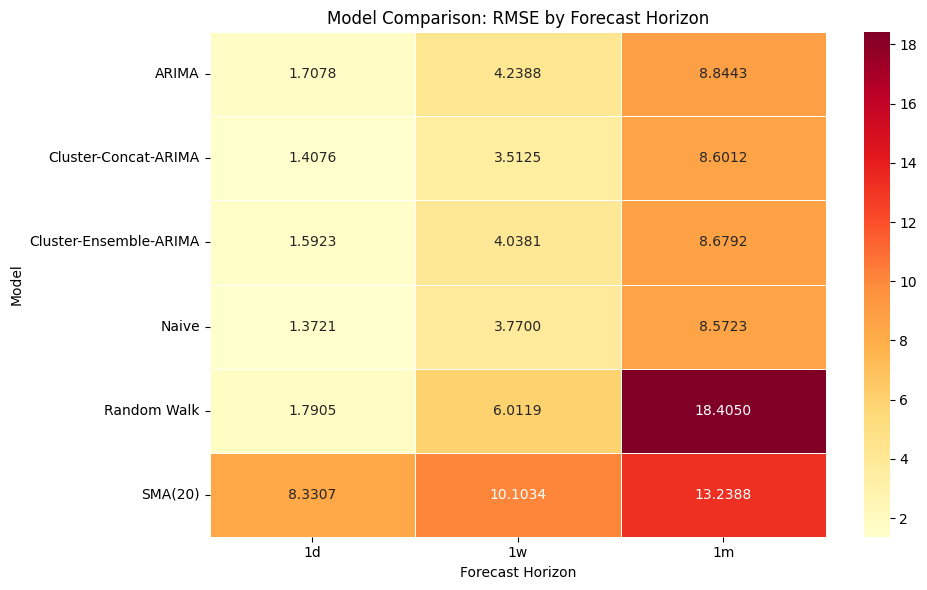

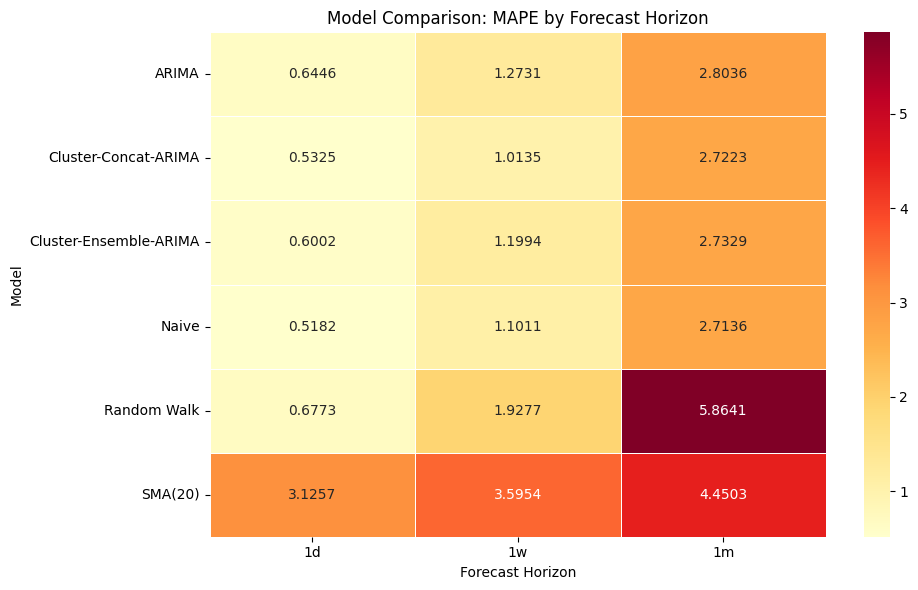

In [7]:
try:
    plot_model_comparison_heatmap(summary, metric="RMSE_mean", save=True, filename="06_model_comparison_rmse.png")
    plot_model_comparison_heatmap(summary, metric="MAPE_mean", save=True, filename="06_model_comparison_mape.png")
except Exception as e:
    print(f"Error creating heatmaps: {e}")

## 6. Metrics Bar Charts

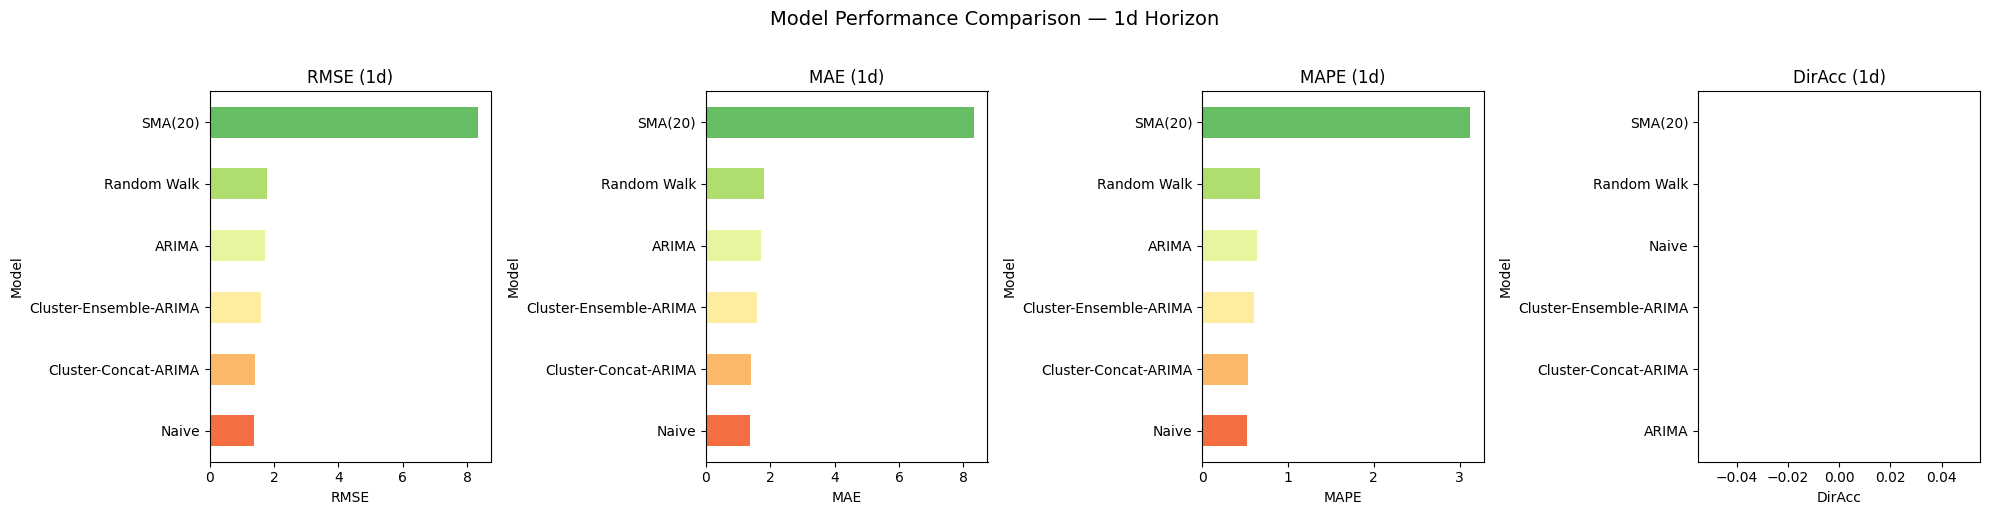

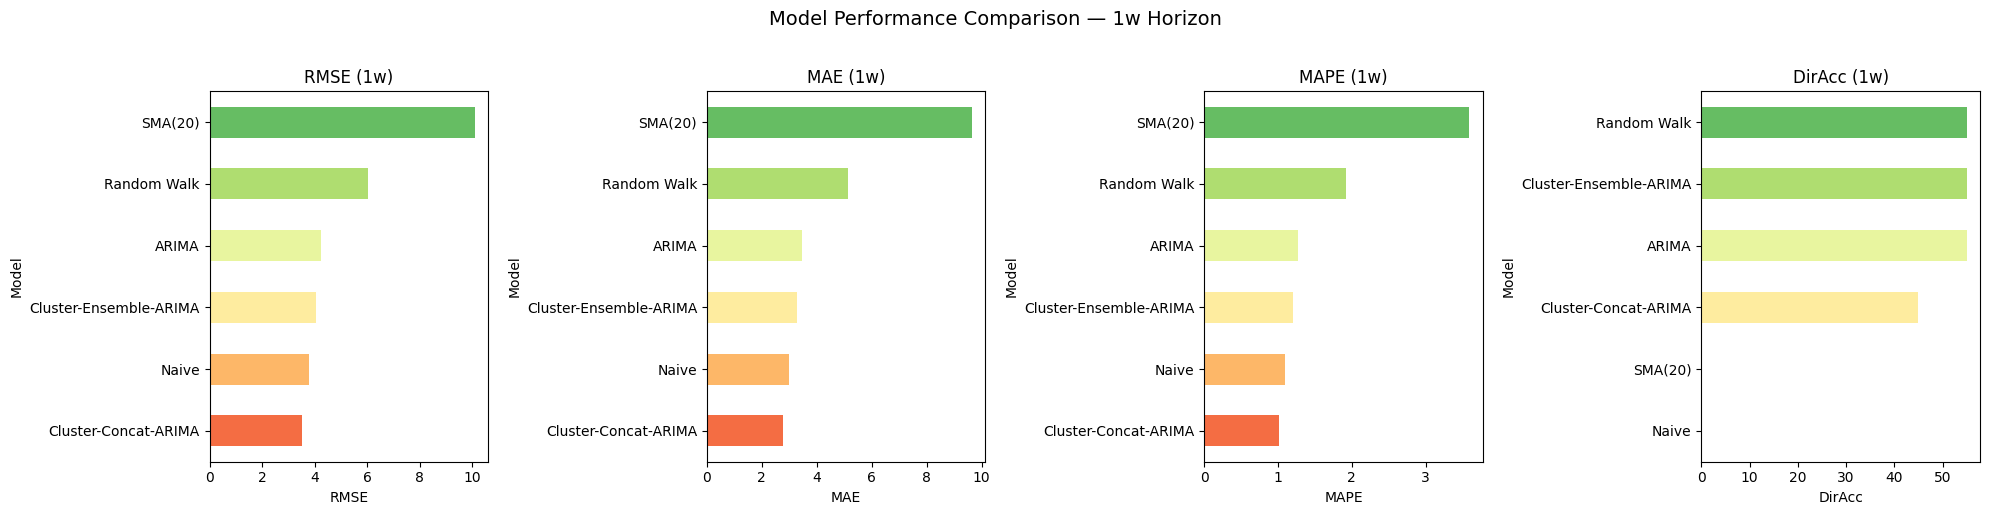

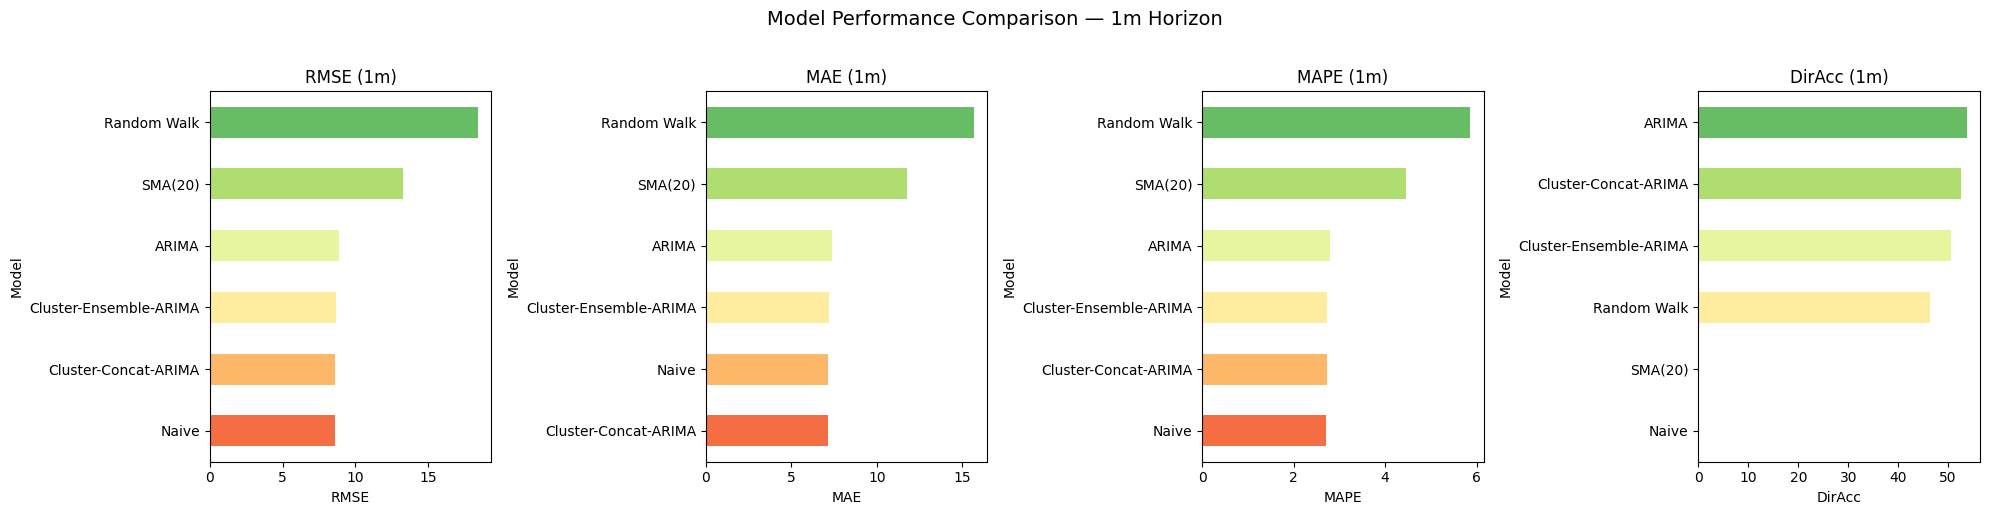

In [8]:
for horizon in ["1d", "1w", "1m"]:
    try:
        plot_metrics_bar_chart(summary, horizon=horizon, save=True, filename=f"06_metrics_{horizon}.png")
    except Exception as e:
        print(f"Skipping {horizon}: {e}")

## 7. Statistical Significance Tests

In [9]:
# Statistical significance: compare forecast errors from backtests
# Include cluster models in comparisons
model_pairs = [
    ('Naive', 'ARIMA'),
    ('Random Walk', 'ARIMA'),
    ('SMA(20)', 'ARIMA'),
    ('ARIMA', 'Cluster-Ensemble-ARIMA'),
    ('ARIMA', 'Cluster-Concat-ARIMA'),
]
stat_results = []

for model1, model2 in model_pairs:
    try:
        errors1 = backtest_results[model1]['RMSE'].values
        errors2 = backtest_results[model2]['RMSE'].values
        result = statistical_test(errors1, errors2)
        result['Model 1'] = model1
        result['Model 2'] = model2
        stat_results.append(result)
    except Exception as e:
        print(f"Error comparing {model1} vs {model2}: {e}")

if stat_results:
    stat_df = pd.DataFrame(stat_results)
    print(stat_df[['Model 1', 'Model 2', 'statistic', 'p_value', 'significant']].to_string(index=False))
else:
    print("No statistical tests completed")

    Model 1                Model 2  statistic  p_value  significant
      Naive                  ARIMA  -2.031130 0.061678        False
Random Walk                  ARIMA   2.018316 0.063141        False
    SMA(20)                  ARIMA   4.075391 0.001135         True
      ARIMA Cluster-Ensemble-ARIMA   2.327013 0.035483         True
      ARIMA   Cluster-Concat-ARIMA   0.390452 0.702079        False


## 8. Multi-Stock Evaluation

In [10]:
multi_ticker_results = []
eval_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

for ticker in eval_tickers:
    if ticker not in stock_data:
        continue
    t_series = stock_data[ticker]["Close"]
    
    # Regular ARIMA
    arima_result = backtest_model(t_series, ARIMAForecast, n_windows=3)
    
    # Cluster-Ensemble ARIMA
    ensemble_result = backtest_cluster_model(
        t_series, ticker, stock_data, kmeans_labels,
        method="ensemble", self_weight=0.5, n_windows=3
    )
    
    # Cluster info
    cid = kmeans_labels.loc[ticker]
    n_peers = (kmeans_labels == cid).sum() - 1
    
    arima_rmse = arima_result['RMSE'].mean()
    ensemble_rmse = ensemble_result['RMSE'].mean()
    improvement = (arima_rmse - ensemble_rmse) / arima_rmse * 100
    
    multi_ticker_results.append({
        'ticker': ticker,
        'cluster': cid,
        'n_peers': n_peers,
        'arima_rmse': arima_rmse,
        'ensemble_rmse': ensemble_rmse,
        'improvement_pct': improvement,
    })
    print(f"{ticker}: ARIMA={arima_rmse:.4f}, Ensemble={ensemble_rmse:.4f}, Δ={improvement:+.2f}%")

multi_ticker_df = pd.DataFrame(multi_ticker_results)
print(f"\nMean improvement: {multi_ticker_df['improvement_pct'].mean():.2f}%")
print(multi_ticker_df.to_string(index=False))

AAPL: ARIMA=4.3113, Ensemble=4.4655, Δ=-3.58%


MSFT: ARIMA=13.0710, Ensemble=12.8351, Δ=+1.80%


GOOGL: ARIMA=11.8721, Ensemble=11.8692, Δ=+0.02%


AMZN: ARIMA=4.8056, Ensemble=4.7597, Δ=+0.96%


NVDA: ARIMA=4.3530, Ensemble=4.3530, Δ=+0.00%

Mean improvement: -0.16%
ticker  cluster  n_peers  arima_rmse  ensemble_rmse  improvement_pct
  AAPL        0       10    4.311290       4.465535    -3.577693e+00
  MSFT        1        5   13.071006      12.835101     1.804797e+00
 GOOGL        5        7   11.872096      11.869195     2.443282e-02
  AMZN        1        5    4.805637       4.759680     9.563167e-01
  NVDA        4        0    4.352954       4.352954     2.040404e-14


## 9. Save Evaluation Results

In [11]:
summary.to_parquet("../data/processed/evaluation_summary.parquet")
if multi_ticker_results:
    multi_ticker_df.to_parquet("../data/processed/multi_ticker_evaluation.parquet")

print("Evaluation results saved.")

Evaluation results saved.
